# Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import matplotlib
import os

from tensorflow import Tensor
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.datasets.fashion_mnist import load_data
from keras import ops
from tensorflow.keras.callbacks import ModelCheckpoint

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Keras version:", keras.__version__)


# List all available physical devices
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# Print device name if GPU is available
if physical_devices:
    print("TensorFlow is using the GPU: ", physical_devices[0].name)
else:
    print("No GPU found. TensorFlow is using the CPU.")

2025-02-22 17:44:01.984018: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 17:44:01.984412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 17:44:01.986429: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 17:44:01.992840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 17:44:02.003511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

TensorFlow version: 2.17.0
NumPy version: 1.26.4
Matplotlib version: 3.10.0
Keras version: 3.4.1
Num GPUs Available:  0
No GPU found. TensorFlow is using the CPU.


I0000 00:00:1740264243.102277  296244 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-22 17:44:03.102526: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Load Fashion Clothes Dataset

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


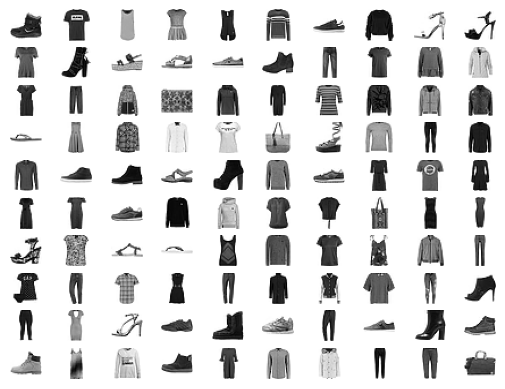

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000,)


In [2]:
def load_real_samples():
    (train_img, train_labels) ,(test_img, test_labels) = load_data()
    for i in range(100):
        plt.subplot(10,10, i+1)
        plt.axis('off') # turn off teh axis labels and ticks for the current subplot, resulted in a cleaner image display
        plt.imshow(train_img[i], cmap='gray_r')
    plt.show()
    all_digits = np.concatenate([train_img, test_img])
    all_labels = np.concatenate([train_labels, test_labels])
    all_digits = np.expand_dims(all_digits, axis = -1) # add a new dimension as the last dimension
    all_digits = all_digits.astype('float32') # convert from int into float
    all_digits =  (all_digits-127.5) / 127.5 # normalize the data between [-1 +1]
    
    print(f"Shape of training images: {all_digits.shape}")
    print(f"Shape of training labels: {all_labels.shape}")

    return [all_digits, all_labels]    

data = load_real_samples()


# Create Dataset

In [3]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((data[0], data[1]))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

I0000 00:00:1723571500.683406  465812 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723571500.683472  465812 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723571500.683484  465812 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723571500.814989  465812 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723571500.815040  465812 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-13

# Create a Discriminator Model

In [4]:
def conv_block (img: Tensor, filter: int):
    x=layers.Conv2D(filters=filter, kernel_size=3, strides=2, padding='same')(img)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)  
    x = layers.Dropout(0.25)(x)  
    return x
# input of the discriminator model is label information and image
def Discriminator(input_shape = ( 28,  28, 1), 
                  n_classes : int = 10, 
                  emb_dim : int = 50,
                  initial_feature_map : int = 128,
                  num_block : int = 2):
    input_image = layers.Input(shape=input_shape) # input of the model with the shape of (Batch_size, 28,  28, 1)
    input_label = layers.Input(shape=(1,)) # input of the model shape (Batch_size, 1)
    emb_vec_label  = layers.Embedding (input_dim= n_classes , output_dim= emb_dim)(input_label)
    n_pixels = input_shape[0] * input_shape[1]
    # convert emb_dim into number of pixels
    emb_vec_label_img = layers.Dense(n_pixels)(emb_vec_label)
    # reshape emb_cev_label_img into shape of the input image
    # In other words, label information is added as a channel to the input image
    emb_vec_label_img = layers.Reshape((input_shape[0]  ,input_shape[1] , input_shape[2]))(emb_vec_label_img)
    
    # Concatenate image and labels as the input of the discriminator process
    x = layers.Concatenate()([input_image, emb_vec_label_img])
    
    for idx  in range(num_block):
        x = conv_block (x, initial_feature_map * (2**idx))
    
    # Global Max Pooling
    x = layers.GlobalMaxPooling2D()(x)  
    
    # output of the discriminator model is a probability
    discriminator_output = layers.Dense(1, activation='sigmoid')(x)
    
    # create discriminator model
    discriminator_model = Model([input_image, input_label] , discriminator_output)
    
    return discriminator_model

discriminator = Discriminator()
#discriminator.summary()

# Create a Generator Model

In [5]:
def upconv_block(x : Tensor, filters: int):
    """Defines an upsampling convolutional block with optional batch normalization."""
    x = layers.Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(alpha = 0.2)(x)
    return x
# input of the generator model is a vector of noise with the length of latent_dim and a label information
# label information and noise vector must be converted into an image shape
# convert into noise vector into (H, W, latent_dim)
# convert label integer into (H, W, 1)
# concatenate (H, W, latent_dim) and (H, W, 1)
def Generator(
              n_classes : int = 10, 
              emb_dim : int = 50,
              num_block : int = 2,
              initial_feature_map : int = 128,
              output_shape : tuple = ( 28, 28,  1)
              ):
    
    # input latent dim
    latent_dim = initial_feature_map * (2**(num_block-1))
    latent_sample_vectors = layers.Input(shape=(latent_dim,)) # the latent noise vector with the shape of (batchsize, latent_dim) 

    latent_label_vectors = layers.Input(shape=(1,)) # a single integer value representing the label as the input of the model  shape of (batchsize, 1)
    # convert the label into an embedding vector with the length of emb_dim
    emb_vec_label = layers.Embedding (input_dim= n_classes, output_dim= emb_dim)(latent_label_vectors)
    
    # Spatial size of the last conv layer before applying GlobalMaxPooling2D
    H_last_conv_layer = output_shape[0] // (2**num_block)
    W_last_conv_layer = output_shape[1] // (2**num_block)
    n_pixels =  H_last_conv_layer * W_last_conv_layer
    
    # convert emb_dim into the H_last_conv_layer and W_last_conv_layer
    emb_vec_label_last_conv = layers.Dense(n_pixels)(emb_vec_label)
    
    # reshape emb_vec_label_last_conv into shape of the last conv layer of discriminator
    emb_vec_label = layers.Reshape ((H_last_conv_layer , W_last_conv_layer, 1))(emb_vec_label_last_conv) 
    
    # number of pixels  of the output the last conv layer
    n_nodes = n_pixels * latent_dim
    
    # convert latent pixels into n_nodes
    gen_noise = layers.Dense(n_nodes)(latent_sample_vectors)
    gen_noise = layers.LeakyReLU(alpha = 0.2)(gen_noise)
    # reshape it into the image shape of the last conv layer output
    gen_noise = layers.Reshape((H_last_conv_layer, W_last_conv_layer, latent_dim)) (gen_noise)
    
    # merge generated noise and label embedding 
    x = layers.Concatenate ()([gen_noise, emb_vec_label]) # (H_last_conv_layer, W_last_conv_layer , latent_dim+1)
    # After concatenating noise and label embeddings:
    for idx in reversed(range(num_block)):
        if idx>0 :
            x = upconv_block (x , initial_feature_map * idx )
        else:
            x = upconv_block (x , 1 )
    # convert the last layer value between -1 and 1
    output_layer = layers.Conv2D(1, 1, activation='tanh', padding= 'same')(x)
    generative_model = Model([latent_sample_vectors, latent_label_vectors] , output_layer)
    
    return generative_model, latent_dim

generator, latent_dim = Generator()
#generator.summary()

/home/saeid23/anaconda3/envs/gan/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


# Create Conditional GAN model

In [6]:
class CGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, n_classes=10):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.disc_loss_real_img = tf.keras.metrics.Mean(name="discriminator_loss_real_images")
        self.disc_loss_fake_img = tf.keras.metrics.Mean(name="discriminator_loss_fake_images")
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
    
    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.disc_loss_real_img, self.disc_loss_fake_img]
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    def generate_latent_points(self, n_samples):
        n_samples = tf.cast(n_samples, tf.int32)  # Cast to an integer tensor, no .numpy() required
        # x_input = tf.random.normal((n_samples, self.latent_dim))  # Use TensorFlow's random normal function
        x_input = keras.random.normal(shape=(n_samples, self.latent_dim), seed=self.seed_generator)  # Use TensorFlow's random normal function
        random_vector_labels = tf.random.uniform((n_samples,), minval=0, maxval=self.n_classes, dtype=tf.int32)
        return x_input, random_vector_labels
    
    def generate_fake_samples(self, n_samples):
        random_latent_vectors, random_vector_labels = self.generate_latent_points(n_samples)
        images = self.generator([random_latent_vectors, random_vector_labels], training=False)  # No need to use .predict()
        y = tf.zeros((n_samples, 1))
        return [images, random_vector_labels], y
        
    def train_step(self, data):
        # Generate real samples
        real_images, real_labels = data
        batch_size = tf.shape(real_images)[0]  # Use tf.shape() instead of ops.shape()
        y_real = tf.ones((batch_size, 1))

        # Generate fake samples
        [fake_images, fake_labels], y_fake = self.generate_fake_samples(batch_size)

        # Train the discriminator
        with tf.GradientTape() as tape:
            self.discriminator.trainable = True
            # Performance of the discriminator model on real images
            pred_real_img = self.discriminator([real_images, real_labels])
            d_loss_real = self.loss_fn(y_real, pred_real_img)
            # Performance of the discriminator model on fake images
            pred_fake_img = self.discriminator([fake_images, fake_labels])
            d_loss_fake = self.loss_fn(y_fake, pred_fake_img)

            # Take average of the losses
            d_loss = (d_loss_real + d_loss_fake) / 2
        # Calculate gradients based on d_loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Update the discriminator's weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points and labels in the latent space.
        random_latent_vectors, random_vector_labels = self.generate_latent_points(batch_size)

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator without updating discriminator's weights
        with tf.GradientTape() as tape:
            fake_img = self.generator([random_latent_vectors, random_vector_labels])
            pred_generated_img = self.discriminator([fake_img, random_vector_labels])
            g_loss = self.loss_fn(misleading_labels, pred_generated_img)
        # Calculate gradients based on g_loss
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        # Update the generator's weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.disc_loss_real_img.update_state(d_loss_real)
        self.disc_loss_fake_img.update_state(d_loss_fake)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "d_loss_real_img": self.disc_loss_real_img.result(),
            "d_loss_fake_img": self.disc_loss_fake_img.result(),
        }

# Instantiate the CGAN model
cond_gan = CGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)

# Save generated images during training

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

class GANImageGenerator(tf.keras.callbacks.Callback):
    def __init__(self, generator, latent_dim, n_classes, num_samples=4, frequency=10, save_dir='./generated_images'):
        self.generator = generator
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.num_samples = num_samples
        self.frequency = frequency
        self.save_dir = save_dir
        self.seed_generator = keras.random.SeedGenerator(1338)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # List of class names for Fashion MNIST dataset
        self.class_names = [
            'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
        ]

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            # Generate random latent points and labels
            random_latent_vectors, random_vector_labels = self.generate_latent_points(self.num_samples)
            # Generate images
            generated_images = self.generator([random_latent_vectors, random_vector_labels], training=False)
            # Save the generated images
            self.save_images(generated_images, random_vector_labels, epoch)

    def generate_latent_points(self, n_samples):
        n_samples = tf.cast(n_samples, tf.int32)
        x_input =  keras.random.normal(shape=(n_samples, self.latent_dim), seed=self.seed_generator)
        random_vector_labels = tf.random.uniform((n_samples,), minval=0, maxval=self.n_classes, dtype=tf.int32)
        return x_input, random_vector_labels

    def save_images(self, images, labels, epoch):
        num_cols = int(np.ceil(np.sqrt(self.num_samples)))
        num_rows = int(np.ceil(self.num_samples / num_cols))
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2), subplot_kw={'xticks': [], 'yticks': []})
        
        for i in range(num_rows * num_cols):
            row = i // num_cols
            col = i % num_cols
            
            if i < self.num_samples:
                img = (images[i] + 1) / 2.0  # Rescale images from [-1, 1] to [0, 1]
                #if img.shape[-1] == 1:  # Check if the image has a single channel
                #    img = tf.squeeze(img)  # Remove the channel dimension
                label = int(labels[i].numpy())
                class_name = self.class_names[label]
                axs[row, col].imshow(img, cmap='gray') 
                axs[row, col].set_title(f'generated {class_name}')
            else:
                axs[row, col].axis('off')  # Hide unused subplots
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch+1}.png'))
        plt.close()

# Instantiate the callback
image_generator_callback = GANImageGenerator(
    generator=generator,
    latent_dim=latent_dim,
    n_classes=10,
    num_samples=12,  # Number of samples to generate
    frequency=10,
    save_dir='./generated_images'  # Directory to save generated images
)

# Assuming `cond_gan` is your GAN model and `generator` is the generator model
checkpoint = ModelCheckpoint(
    filepath='./saved_models/best_generator_epoch_{epoch:04d}.weights.h5',  # Path where the model will be saved
    monitor='g_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # We want to minimize the loss
    save_weights_only=True,  # Save only the generator weights
    verbose=1  # Verbosity mode, 1 for progress updates
)

# Training the Conditional GAN

In [8]:
# You can now compile the model and start training
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
    loss_fn= keras.losses.BinaryCrossentropy(from_logits=False),
)
history = cond_gan.fit(dataset, 
                       epochs=200,
                       batch_size=64,
                       callbacks=[checkpoint, image_generator_callback]
                       )

Epoch 1/200


I0000 00:00:1723571504.100846  465935 service.cc:146] XLA service 0x7f713801bc70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723571504.100894  465935 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-08-13 13:51:44.173053: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-13 13:51:44.332751: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:107] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-08-13 13:51:44.569568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  14/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - d_loss: 0.4605 - d_loss_fake_img: 0.6993 - d_loss_real_img: 0.2218 - g_loss: 0.8069

I0000 00:00:1723571508.795493  465935 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - d_loss: 0.0982 - d_loss_fake_img: 0.1195 - d_loss_real_img: 0.0768 - g_loss: 8.5097
Epoch 1: g_loss improved from inf to 9.84651, saving model to ./saved_models/best_generator_epoch_0001.weights.h5


W0000 00:00:1723571523.731447  465812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723571523.741337  465812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723571523.742681  465812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723571523.744221  465812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723571523.749561  465812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723571523.753691  465812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723571523.755486  465812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723571523.756969  465812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723571523.758574  465812 gp

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - d_loss: 0.0981 - d_loss_fake_img: 0.1195 - d_loss_real_img: 0.0768 - g_loss: 8.5109
Epoch 2/200
1091/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - d_loss: 0.0844 - d_loss_fake_img: 0.0695 - d_loss_real_img: 0.0992 - g_loss: 6.5842
Epoch 2: g_loss improved from 9.84651 to 6.42684, saving model to ./saved_models/best_generator_epoch_0002.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - d_loss: 0.0844 - d_loss_fake_img: 0.0696 - d_loss_real_img: 0.0992 - g_loss: 6.5836
Epoch 3/200
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - d_loss: 0.0974 - d_loss_fake_img: 0.0806 - d_loss_real_img: 0.1142 - g_loss: 5.5810
Epoch 3: g_loss improved from 6.42684 to 5.73578, saving model to ./saved_models/best_generator_epoch_0003.weights.h5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - d_loss: 0.0974 - d_loss_fake_img: 0.0806 - d_loss_real_img: 0.1142 - g_loss: 5.5811
Epoch 4/200
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - d_loss: 0.0614 - d_loss_fake_i